## Evaluating the Parameter server from scratch

This notebook has the goal of evaluating the performance of the parameter server from scratch implementation. It will be compared to the built-in parameter server implementation from the `torch.nn.parallel` module.

### Parameter Server from scratch

Parmeter server is a technique for data parallel training of deep learning models. We have two types of nodes: server node and worker nodes. In our case, node == GPU == process.

**One cycle of updates**: Server sends the current parameters of the model to all the workers. Workers perform several backpropagation cycles and accumulate the gradients (without performing a gradient descent step). All the workers then send the gradients to the server, which averages them and updates the model parameters. The server then sends the updated parameters to all the workers. The updates happend synchronously.

All the synchronizations are computed after one epoch, for simplicity. For training, a dataset of 1000 MNIST examples is used, to keep the training task relatively simple.

Let's start with importing necessary packages.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import os

Let's first plot the training accuracy and loss with respect to the number of epochs. This will give us an idea if the model is learning. 

In [2]:
logs_path = 'logs'
acc_path = os.path.join(logs_path, 'my_param_server_acc.csv')
loss_path = os.path.join(logs_path, 'my_param_server_loss.csv')

In [3]:
acc_df = pd.read_csv(acc_path)[['devout-grass-22 - training acc']].rename(columns={'devout-grass-22 - training acc': 'acc'})
loss_df = pd.read_csv(loss_path)[['devout-grass-22 - training loss']].rename(columns={'devout-grass-22 - training loss': 'loss'})
df = pd.concat([acc_df, loss_df], axis=1)

Text(0.5, 0.98, 'Training of from-scratch implementation of Parameter Server')

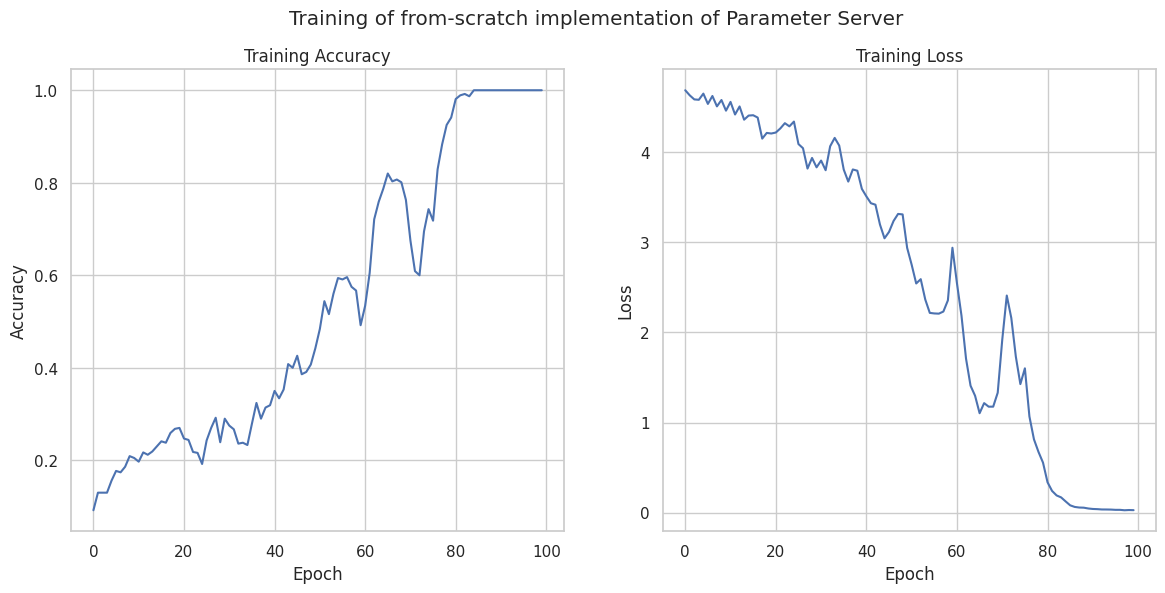

In [4]:
# scatter the training accuracy and training time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=df, x=df.index, y='acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=df, x=df.index, y='loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# subtitle
plt.suptitle('Training of from-scratch implementation of Parameter Server')


We can see that the model is able to overfit to the training data (that is a great sign, despite the name :D ) 

Let's compare to the builtin implementation of the parameter server.

In [5]:
builtin_loss_path = os.path.join(logs_path, 'builtin_param_loss.csv')
builtin_acc_path = os.path.join(logs_path, 'builtin_param_acc.csv')

builtin_loss_df = pd.read_csv(builtin_loss_path)[['lunar-spaceship-8 - train_loss']].rename(columns={'lunar-spaceship-8 - train_loss': 'loss'})
builtin_acc_df = pd.read_csv(builtin_acc_path)[['lunar-spaceship-8 - train_acc']].rename(columns={'lunar-spaceship-8 - train_acc': 'acc'})

builtin_acc_df['acc'] = builtin_acc_df['acc'] / builtin_acc_df['acc'].max()

builtin_df = pd.concat([builtin_acc_df, builtin_loss_df], axis=1)

Text(0.5, 0.98, 'Training of Builtin Parameter Server')

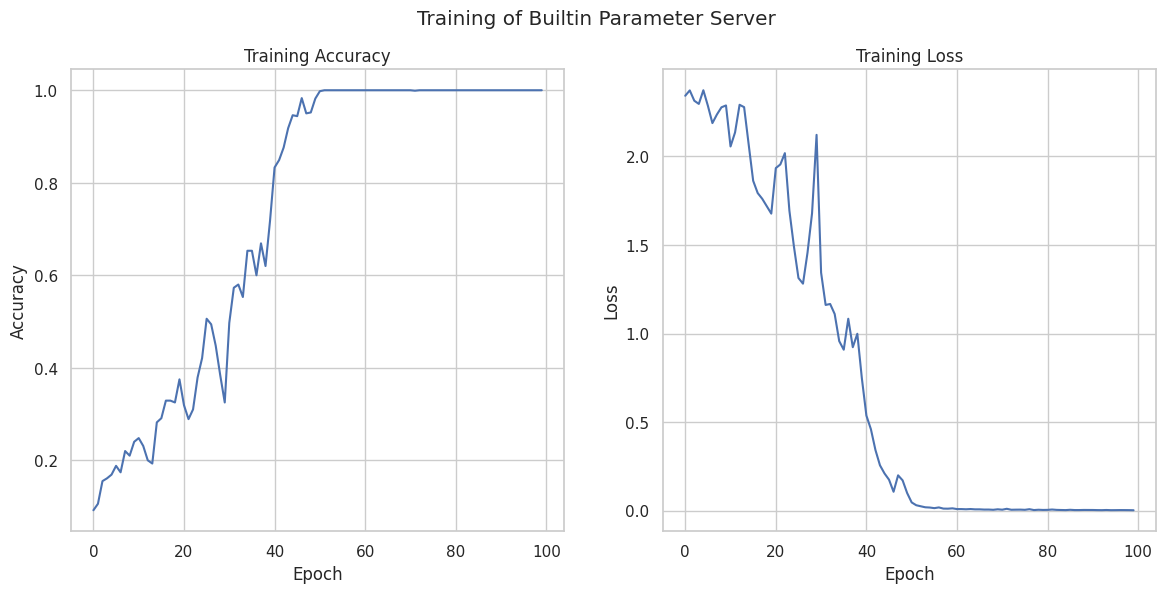

In [6]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=builtin_df, x=builtin_df.index, y='acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=builtin_df, x=builtin_df.index, y='loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# subtitle
plt.suptitle('Training of Builtin Parameter Server')



We can see that the builtin method achieves the 100% accuracy in 40 epochs, while the from scratch implementation needes 80 epochs (2x more). Let's compare the time - performance plot, for more accurate comparison.

In [7]:
time_path = os.path.join(logs_path, 'my_param_server_time.csv')
time_df = pd.read_csv(time_path)[['devout-grass-22 - Time']].rename(columns={'devout-grass-22 - Time': 'time'})

In [8]:
builtin_time_path = os.path.join(logs_path, 'builtin_param_time.csv')
builtin_time_df = pd.read_csv(builtin_time_path)[['lunar-spaceship-8 - time']].rename(columns={'lunar-spaceship-8 - time': 'time'})

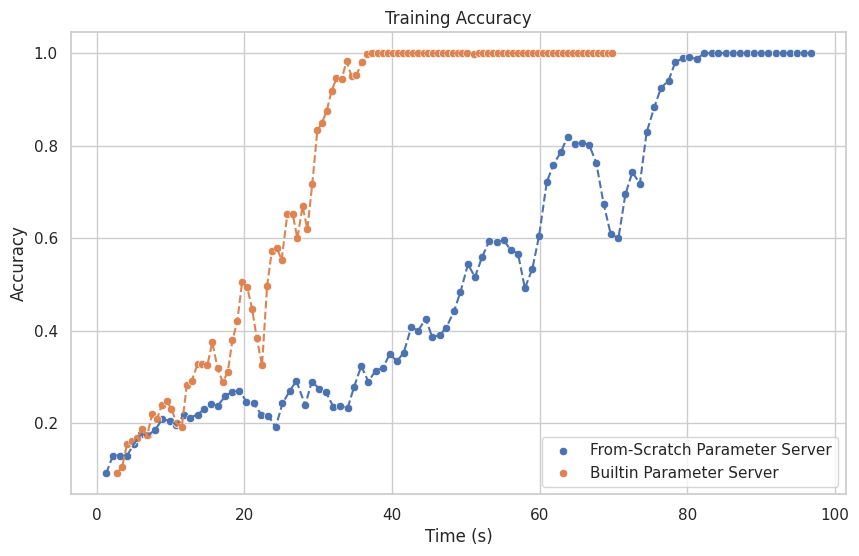

In [9]:
time_acc_df = pd.concat([time_df, acc_df], axis=1)
builtin_time_acc_df = pd.concat([builtin_time_df, builtin_acc_df], axis=1)

plt.figure(figsize=(10, 6))

sns.scatterplot(data=time_acc_df, x='time', y='acc', label='From-Scratch Parameter Server')
# dash line to connect the scattered points
plt.plot(time_acc_df['time'], time_acc_df['acc'], linestyle='dashed')

sns.scatterplot(data=builtin_time_acc_df, x='time', y='acc', label='Builtin Parameter Server')
plt.plot(builtin_time_acc_df['time'], builtin_time_acc_df['acc'], linestyle='dashed')


plt.title('Training Accuracy')
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.legend()




We can see that the builtin method achieves the 100% accuracy around 2x faster than the from scratch implementation. Let's try to see what is the bottleneck.

In [13]:
df_epoch_calc = pd.read_csv(os.path.join(logs_path, 'my_param_epoch_calc.csv')).rename(columns={'dainty-voice-24 - epoch_calculation_time': 'calc'})[['calc']]

In [14]:
df_epoch_calc.sum()

calc    7.32291
dtype: float64